# Square Robot data exploration

## LWLD File Format

### Goal:  How can we extract data from this format for processing in our pipelines

In [1]:
from datetime import datetime
import difflib
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import struct
import sys
sys.path.insert(0, '..')
import time
import warnings
import zlib

from libs.parsers.square_formats import FileHeader, String, ProbeData, DepthReceptions, Entry, SquareData

### NOTE: the following function has been provided by Jerome from Square Robot for processing their data

In [2]:
## NOTE: the following function has been provided by Jerome from Square Robot for processing their data

def get_ms_prefix_length_string( lwld_file ):
    """
    
    """
    str_len_byte = struct.unpack( 'B', lwld_file.read(1) )[0]
    str_len = ( str_len_byte & 0x7F )
    shift_count = 1
    # This section is kind of from AOS and untested until a string is greater the 127 bytes
    
    while str_len_byte > 127:
        str_len_byte = struct.unpack( 'B', lwld_file.read(1) )[0]
        add_len = ( str_len_byte & 0x7F )
        add_len = add_len << (shift_count*7)
        str_len = str_len + add_len
        shift_count = shift_count + 1
    if str_len == 0:
        return ""
    return (lwld_file.read( str_len )).decode( 'utf-8' )

### Read in File

In [3]:
lwld_file = r'../data/raw_data/square/2023_03_18_1679119860_ASAP_FRS_10.1_1679119919.417.lwld'

In [4]:
test_file = open(lwld_file, "rb")

## Get length of the full file 

In [5]:
full_file = test_file.read()

In [6]:
len(full_file)

752071739

Create a test file

In [7]:
test_var = full_file #test_file.read(10000)

In [8]:
len(test_var)

752071739

Test FileHeader Class and get length

In [9]:
f = FileHeader(test_var)

In [10]:
len(f)

475

In [11]:
header_length = len(f)

Check we actually get data

In [12]:
f.contents.get("point_factor")

2.0

In [13]:
f.contents.get("num_selected_probes")

8

Calculate size of "Probe Data"

In [14]:
482*f.contents.get("num_selected_probes")

3856

In [15]:
probe_data_length = 482*f.contents.get("num_selected_probes")

### Notes:

- 'num_points' is the number of RF readings in a single A-scan waveform
- 'num_cycles' is the number of A-scans in a single sequence taken at a single timestamp
- 'encoder_size' is the number of timestamps in the file, and the number of sequences of data collected

This means for the example file, 2,566 sequences, where each sequence consists of 208 A-scans, each A-scan is made up of 1,401 readings

Length of Raw PAUT waveform data is calculated as product of these three

In [16]:
f.contents.get("encoder_size") # number of timestamps in the file, and the number of sequences collected

2566

In [17]:
f.contents.get("num_cycles") # maybe the 208 is the number of focal logs so that would be the number of A-scans maybe, number of A-scans in a single sequence

208

In [18]:
f.contents.get("num_points") # number of readings in a single A-scan waveform

1401

In [19]:
f.contents.get("encoder_size") * f.contents.get("num_cycles") * f.contents.get("num_points")

747752928

In [20]:
raw_paut_waveform_data_length = f.contents.get("encoder_size") * f.contents.get("num_cycles") * f.contents.get("num_points")

In [21]:
String(test_var[128:160])

String(len=14, value=b'1679119860.037')

In [22]:
f.contents.get("posix_time_start")

b'1679119860.037'

In [23]:
f.contents.get("posix_time_end").decode('utf-8')

'1679119919.417'

In [24]:
time.time()

1684769556.0098164

In [25]:
datetime.fromtimestamp(1679119860.037)

datetime.datetime(2023, 3, 18, 2, 11, 0, 37000)

In [26]:
datetime.fromtimestamp(1679119919.417)

datetime.datetime(2023, 3, 18, 2, 11, 59, 417000)

In [27]:
start_time = datetime.fromtimestamp(float(f.contents.get("posix_time_start").decode('utf-8')))
end_time = datetime.fromtimestamp(float(f.contents.get("posix_time_end").decode('utf-8')))

In [28]:
f.contents.get("nav_trackline_id")

b'1679119860_ASAP_FRS_10.1'

In [29]:
f.contents.get("nav_num_pulses")

b'464'

In [30]:
f.contents.get("master_setup_filename")

b'master_-6us_28range-1510mps.txt'

In [31]:
f.contents.get("slave_setup_filename")

b'slave_-6us_28range-1510mps.txt'

In [32]:
f.contents.get("num_selected_probes")

8

In [33]:
f.contents.get("dac_enabled")

False

In [34]:
header_length

475

In [35]:
header_length + probe_data_length

4331

In [36]:
p = ProbeData(test_var[header_length:header_length + probe_data_length])

In [37]:
len(p)

482

In [38]:
p.contents

{'selected': True,
 'element_count': 32,
 'pitch': 1.5,
 'frequency': 10.0,
 'radius': 0.0,
 'wedge_enable': True,
 'wedge_velocity': 1510.0,
 'wedge_height': 46.0,
 'wedge_angle': 0.0,
 'specimen_velocity': 5800.0,
 'specimen_wave': 0,
 'specimen_radius': 0.0,
 'elem_count': 7,
 'depth_emission': 7.0,
 'depth_reception_array': b'y\xe9&1\x08\xac|?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [39]:
p.contents.get("depth_emission")

7.0

In [40]:
p2 = ProbeData(test_var[header_length + len(p):header_length + probe_data_length])

In [41]:
p2.contents

{'selected': True,
 'element_count': 32,
 'pitch': 1.5,
 'frequency': 10.0,
 'radius': 0.0,
 'wedge_enable': True,
 'wedge_velocity': 1510.0,
 'wedge_height': 46.0,
 'wedge_angle': 0.0,
 'specimen_velocity': 5800.0,
 'specimen_wave': 0,
 'specimen_radius': 0.0,
 'elem_count': 7,
 'depth_emission': 7.0,
 'depth_reception_array': b'y\xe9&1\x08\xac|?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [42]:
header_length + 86

561

In [43]:
32*8

256

In [44]:
561 + 256

817

In [45]:
test_var[561:817]

b'y\xe9&1\x08\xac|?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [46]:
DepthReceptions(test_var[561:817])

DepthReceptions(value=b'y\xe9&1\x08\xac|?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [47]:
4331+192

4523

In [48]:
test_var[4331:4523]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [49]:
test_Square = SquareData(test_var)

In [50]:
test_Square

In [51]:
test_Square.header.contents

{'encoder_size': 2566,
 'num_cycles': 208,
 'num_points': 1401,
 'bit_size': 0,
 'scan_length': 2.566,
 'scan_step': 0.001,
 'sampling_period': 2e-08,
 'vel_1': 6300.0,
 'vel_2': 6300.0,
 'vel_3': 6300.0,
 'thickness': 0.01,
 'ascan_type': 0,
 'vel_couplant': 1500.0,
 'ascan_type2': 0,
 'sw_version': 2,
 'probe_mode': 1,
 'num_selected_probes': 8,
 'ascan_start': 55.161924,
 'ascan_range': 28.0,
 'compression_type': 1,
 'point_factor': 2.0,
 'posix_time_start': b'1679119860.037',
 'posix_time_end': b'1679119919.417',
 'nav_trackline_id': b'1679119860_ASAP_FRS_10.1',
 'nav_num_pulses': b'464',
 'reserved1': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [52]:
test_Square.probe_data[7].contents

{'selected': True,
 'element_count': 32,
 'pitch': 1.5,
 'frequency': 10.0,
 'radius': 0.0,
 'wedge_enable': True,
 'wedge_velocity': 1510.0,
 'wedge_height': 46.0,
 'wedge_angle': 0.0,
 'specimen_velocity': 5800.0,
 'specimen_wave': 0,
 'specimen_radius': 0.0,
 'elem_count': 7,
 'depth_emission': 7.0,
 'depth_reception_array': b'y\xe9&1\x08\xac|?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [53]:
test_Square.angles_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [54]:
len(test_Square.angles_array)

208

In [55]:
test_Square.exits_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [56]:
len(test_Square.exits_array)

208

In [57]:
test_Square.raw_paut_waveform_data

array([[[-1, -1,  0, ..., -3, -3,  0],
        [ 0,  0,  0, ..., -1, -2,  0],
        [ 0,  0, -1, ..., -2, -5,  0],
        ...,
        [ 0, -1, -1, ...,  0,  0,  0],
        [ 1,  1,  1, ...,  1,  1,  0],
        [ 1,  1,  1, ..., -1, -2,  0]],

       [[ 0,  0,  0, ..., -2, -2,  0],
        [ 0,  0,  0, ..., -1, -2,  0],
        [ 0,  0,  0, ..., -2, -5,  0],
        ...,
        [ 0,  0,  0, ...,  0, -1,  0],
        [ 1,  1,  0, ..., -1, -2,  0],
        [-1, -2, -2, ..., -2, -2,  0]],

       [[ 0,  0,  0, ..., -2, -1,  0],
        [ 0,  0, -1, ..., -2, -3,  0],
        [-1, -1, -1, ..., -5, -8,  0],
        ...,
        [ 0,  0,  0, ..., -1, -1,  0],
        [-1, -1,  0, ...,  0, -1,  0],
        [ 0,  0,  0, ..., -1, -1,  0]],

       ...,

       [[ 0,  0,  0, ...,  1,  2,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  1,  1,  0],
        ...,
        [-1, -1,  0, ...,  0,  1,  0],
        [ 0,  0,  0, ...,  1,  2,  0],
        [ 1,  1,  1, ...,  2,  3

In [58]:
test_Square.raw_paut_waveform_data

array([[[-1, -1,  0, ..., -3, -3,  0],
        [ 0,  0,  0, ..., -1, -2,  0],
        [ 0,  0, -1, ..., -2, -5,  0],
        ...,
        [ 0, -1, -1, ...,  0,  0,  0],
        [ 1,  1,  1, ...,  1,  1,  0],
        [ 1,  1,  1, ..., -1, -2,  0]],

       [[ 0,  0,  0, ..., -2, -2,  0],
        [ 0,  0,  0, ..., -1, -2,  0],
        [ 0,  0,  0, ..., -2, -5,  0],
        ...,
        [ 0,  0,  0, ...,  0, -1,  0],
        [ 1,  1,  0, ..., -1, -2,  0],
        [-1, -2, -2, ..., -2, -2,  0]],

       [[ 0,  0,  0, ..., -2, -1,  0],
        [ 0,  0, -1, ..., -2, -3,  0],
        [-1, -1, -1, ..., -5, -8,  0],
        ...,
        [ 0,  0,  0, ..., -1, -1,  0],
        [-1, -1,  0, ...,  0, -1,  0],
        [ 0,  0,  0, ..., -1, -1,  0]],

       ...,

       [[ 0,  0,  0, ...,  1,  2,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  1,  1,  0],
        ...,
        [-1, -1,  0, ...,  0,  1,  0],
        [ 0,  0,  0, ...,  1,  2,  0],
        [ 1,  1,  1, ...,  2,  3

In [59]:
len(test_Square.raw_paut_waveform_data)

2566

In [60]:
test_Square.raw_paut_waveform_data.max()

127

In [61]:
test_Square.raw_paut_waveform_data.min()

-128

In [62]:
round(100*len(test_Square.raw_paut_waveform_data)/len(full_file),2)

0.0

In [63]:
test_Square.raw_paut_waveform_data.shape = (
    test_Square.header.contents.get("encoder_size"),
    test_Square.header.contents.get("num_cycles"),
    test_Square.header.contents.get("num_points")
)

In [64]:
test_Square.probe_numbers_array

array([-168561674,   84082425,   67569671, ...,   33949439,  369754623,
        169419296])

In [65]:
test_Square.digital_inputs_array

array([-67372037, -50595077, 100926206, ...,  84082941,  16909061,
       -67239936])

In [66]:
test_Square.timestamps_array

array([-5.31401565e+303,              nan, -4.54358545e+279, ...,
        2.43303202e-173, -1.43196317e-049, -6.44123849e+203])

In [67]:
len(test_Square.raw_paut_waveform_data)/len(test_Square.timestamps_array)

1.0

In [68]:
test_Square.gates

In [69]:
test_Square.header.contents

{'encoder_size': 2566,
 'num_cycles': 208,
 'num_points': 1401,
 'bit_size': 0,
 'scan_length': 2.566,
 'scan_step': 0.001,
 'sampling_period': 2e-08,
 'vel_1': 6300.0,
 'vel_2': 6300.0,
 'vel_3': 6300.0,
 'thickness': 0.01,
 'ascan_type': 0,
 'vel_couplant': 1500.0,
 'ascan_type2': 0,
 'sw_version': 2,
 'probe_mode': 1,
 'num_selected_probes': 8,
 'ascan_start': 55.161924,
 'ascan_range': 28.0,
 'compression_type': 1,
 'point_factor': 2.0,
 'posix_time_start': b'1679119860.037',
 'posix_time_end': b'1679119919.417',
 'nav_trackline_id': b'1679119860_ASAP_FRS_10.1',
 'nav_num_pulses': b'464',
 'reserved1': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [70]:
test_Square.probe_data

In [71]:
test_Square.probe_data[2].contents

{'selected': True,
 'element_count': 32,
 'pitch': 1.5,
 'frequency': 10.0,
 'radius': 0.0,
 'wedge_enable': True,
 'wedge_velocity': 1510.0,
 'wedge_height': 46.0,
 'wedge_angle': 0.0,
 'specimen_velocity': 5800.0,
 'specimen_wave': 0,
 'specimen_radius': 0.0,
 'elem_count': 7,
 'depth_emission': 7.0,
 'depth_reception_array': b'y\xe9&1\x08\xac|?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [72]:
def scott_abs(ascan):
    temp = np.where(ascan == -(2**7), -(2**7) + 1, ascan)
    return np.abs(temp)

2,566 sequences, where each sequence consists of 208 A-scans, each A-scan is made up of 1,401 readings



## B-scan - side view across whole scan, 1 probe

Text(0.5, 1.0, 'B-scan')

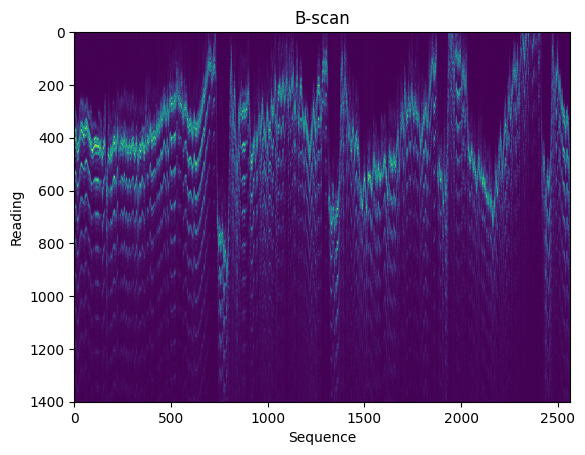

In [84]:
clean_data = test_Square.raw_paut_waveform_data[:, 200, :][()]
clean_data = clean_data.T
#clean_data

img_data = scott_abs(clean_data)

plt.imshow(img_data, aspect="auto")

plt.xlabel('Sequence')
plt.ylabel('Reading')
plt.title('B-scan')

## D-scan - end view looking at backside of transducers

"L-scan" is a linear S scan, which is what Square calls it

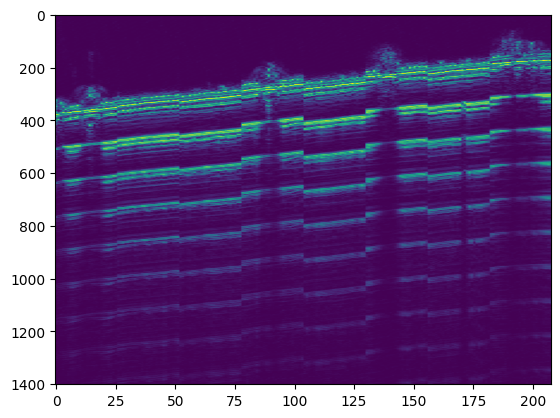

In [85]:
clean_data = test_Square.raw_paut_waveform_data[2500, :, :][()]
clean_data = clean_data.T
#clean_data

img_data = scott_abs(clean_data)

plt.imshow(img_data, aspect="auto")

In [76]:
sample_waveform = img_data[:, 207]

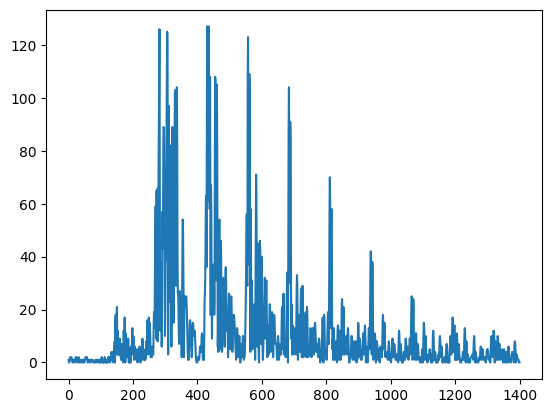

In [77]:
plt.plot(sample_waveform)

In [78]:
from gecko import gates

ModuleNotFoundError: No module named 'gecko'

In [79]:
import gecko

ModuleNotFoundError: No module named 'gecko'

In [81]:
import gecko.gates

ModuleNotFoundError: No module named 'gecko'

In [ ]:
0xe9

In [ ]:
0x08

In [ ]:
0x0e

In [ ]:
bin(0x0e) # these are the bits in the byte, not an ASCE character

In [ ]:
print(b'\x0e')